In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


con = sqlite3.connect('../remote.db')

# Questions

## Q1 . Find the Highest Transaction of each month in the year 2012 for the Product "Sport-100 Helmet, Red"

In [8]:
qa1 = pd.read_sql_query("""
WITH data AS (
SELECT 
	dp."ProductKey", 
	strftime('%Y', frs."OrderDate") AS year_order,
	strftime('%m',  frs."OrderDate") AS month,
	frs."OrderDate" as order_date, 
	frs."SalesAmount" as sales_amount
FROM 
	factresellersales_normalized frs
JOIN 
	dimproduct_normalized dp
	ON dp."ProductKey" = frs."ProductKey"
WHERE 
	dp."ProductName" LIKE 'Sport-100 Helmet, Red'
	AND strftime('%Y', frs."OrderDate") = '2012'
)

SELECT 
	month, sales_amount, order_date
FROM (
	SELECT 
		month, sales_amount, order_date, 
		RANK() OVER (
		PARTITION BY month order by sales_amount desc ) as rnk
	FROM data
	ORDER BY month desc, sales_amount desc
) as base
WHERE 
	rnk = 1
order by month asc
""",con=conn_s)

df = qa1.copy()

In [9]:
display(df)

,month,sales_amount,order_date
0,01,267.7266,2012-01-29 00:00:00.000000
1,02,421.8980,2012-02-29 00:00:00.000000
2,03,229.4799,2012-03-30 00:00:00.000000
3,04,210.3566,2012-04-30 00:00:00.000000
4,05,229.4799,2012-05-30 00:00:00.000000
5,06,141.3055,2012-06-30 00:00:00.000000
6,07,161.4920,2012-07-31 00:00:00.000000
7,08,201.8650,2012-08-28 00:00:00.000000
8,09,267.7266,2012-09-28 00:00:00.000000
9,10,229.4799,2012-10-28 00:00:00.000000


/Users/manfredi/miniconda3/envs/remote/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month'>

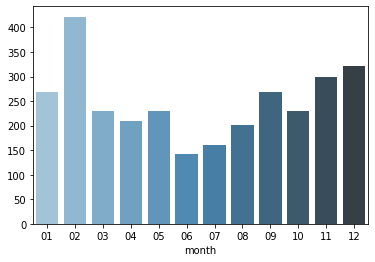

In [10]:
sns.barplot(df.month, df.sales_amount.values, palette="Blues_d") 

## Q2. Find the lowest revenue-generating product for each month in the Year – **2012**.  Include the **Sales Territory Country** as well.

Given that the focus, based on the question, seems to be the product rather than the cross product between product and sales territory, I'm assuming that the expected output would be to have the 12 months of the year with the lowest selling product with the additional information of the country.

I used to different angles to explore the data, focusing on the country and on the product. The chart that shows the lowest selling product by country suggests a nice insights that the UK is often present with low selling products

In [11]:
qa2 = pd.read_sql_query("""
WITH data AS (
SELECT 
 dp."ProductName" AS product_name, 
 dst."SalesTerritoryCountry" AS sales_territory_country,
 strftime('%m',  frs."ShipDate") AS month,
 SUM(frs."SalesAmount") AS sales_amount

FROM 
	factresellersales_normalized frs
JOIN 
	dimproduct_normalized dp
	ON dp."ProductKey" = frs."ProductKey"
JOIN 
	dimsalesterritory_normalized dst
	ON frs."SalesTerritoryKey" = dst."SalesTerritoryKey"
WHERE 
	strftime('%Y',  frs."ShipDate") = '2012'
GROUP BY product_name, sales_territory_country, month
)

SELECT 
	DISTINCT
	month, sales_territory_country, product_name, sales_amount
FROM (
	SELECT 
		month, sales_territory_country, product_name, sales_amount,
		RANK() OVER (
		PARTITION BY month order by sales_amount asc ) AS rnk
	FROM data
	ORDER BY month DESC, sales_amount ASC
) as base
WHERE 
	rnk = 1
ORDER BY month ASC""",con=conn_s)

df = qa2.copy()

In [12]:
display(qa2)

,month,sales_territory_country,product_name,sales_amount
0,01,France,"Half-Finger Gloves, S",28.2578
1,02,United Kingdom,LL Road Handlebars,24.2945
2,03,France,AWC Logo Cap,10.3730
3,04,United Kingdom,"Half-Finger Gloves, L",14.1289
4,05,Canada,LL Mountain Handlebars,24.2945
5,06,United Kingdom,AWC Logo Cap,10.3730
6,07,France,AWC Logo Cap,10.3730
7,08,United Kingdom,Minipump,23.9880
8,09,France,"Half-Finger Gloves, S",14.1289
9,10,United Kingdom,Minipump,11.9940


/Users/manfredi/miniconda3/envs/remote/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


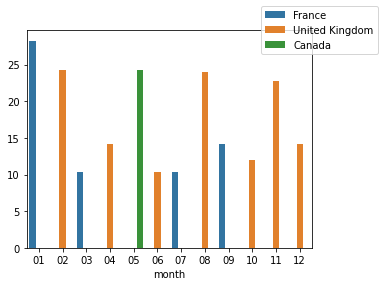

In [31]:
fig, ax1 = plt.subplots(1,1, figsize = (6, 4))

f = sns.barplot(df.month, df.sales_amount.values, hue=df.sales_territory_country)

box = f.get_position()
f.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
f.legend(loc='center right', bbox_to_anchor=(1.25, 1.0), ncol=1)

plt.show()

/Users/manfredi/miniconda3/envs/remote/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


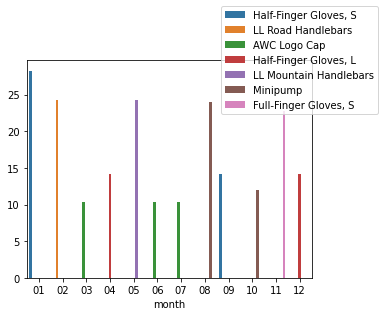

In [32]:
fig, ax1 = plt.subplots(1,1, figsize = (6, 4))

f = sns.barplot(df.month, df.sales_amount.values, hue=df.product_name)

box = f.get_position()
f.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
f.legend(loc='center right', bbox_to_anchor=(1.25, 1.0), ncol=1)

plt.show()

## Q3 . Find the Average Finance Amount for each Scenario for each Account Type for the year 2011

By exploring the table FactFinance I notice that I only see two ScenarioKey (1,2), corresponding to Budget and Actual. There is no "Forecast" Scenario. In my mind this makes sense if the data I'm looking at is historical, thus there won't be any forecast but only actuals. The presence of Budget of Revenue and Expenditure suggests that these line items are kept as benchmark against the actual (personal interpretation)


In [38]:
qa3 = pd.read_sql_query ("""
SELECT 
	da."AccountType",
	AVG(CASE WHEN ds."ScenarioName" LIKE 'Actual' THEN ff."Amount" END) AS ActualScenario,
	AVG(CASE WHEN ds."ScenarioName" LIKE 'Budget' THEN ff."Amount" END) as BudgetScenario, 
	AVG(CASE WHEN ds."ScenarioName" LIKE 'Forecast' THEN ff."Amount" END) AS ForecastScenario 
FROM 
	factfinance_normalized ff
JOIN 
	dimaccounts_normalized da
	ON da."AccountKey" = ff."AccountKey"
JOIN 
	dimscenario_normalized ds
	ON ds."ScenarioKey" = ff."ScenarioKey"
WHERE 
	strftime('%Y',  ff."Date")  = '2011'
GROUP BY da."AccountType"

""", con = conn_s)

df = qa3.copy()

In [39]:
display(df)

,AccountType,ActualScenario,BudgetScenario,ForecastScenario
0,Assets,110701.156199,NaN,None
1,Balances,11256.932886,NaN,None
2,Expenditures,3647.767538,3757.806122,None
3,Flow,382.445946,NaN,None
4,Liabilities,119785.411384,NaN,None
5,Revenue,30876.129243,186287.878788,None


<AxesSubplot:>

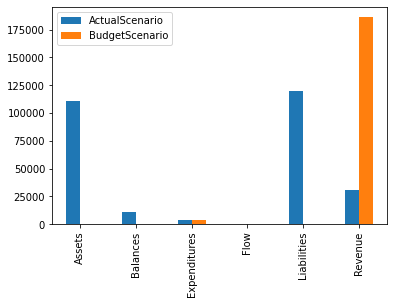

In [41]:
img = pd.DataFrame(
    {
        'ActualScenario': list(df.ActualScenario), 
        'BudgetScenario': list(df.BudgetScenario), 
        'ForecastScenario': list(df.ForecastScenario), 
    },
    index = list(df.AccountType)
)
img.plot.bar()

## Q4. Find all the products and their Total Sales Amount by Month of order which does have sales in the year – 2012

We have a number of product keys, so the visualization is very clogged. A way I would use to improve the redeability of this visualization is to use Product Categories rather than product keys to see driving trends for products belonging to the same category.

In [47]:
qa4 = pd.read_sql_query("""
SELECT 
	dp."ProductKey",
	SUM(frs."SalesAmount") as SalesAmount,
	strftime('%m',  frs."OrderDate") AS OrderMonth
FROM 
	factresellersales_normalized frs
JOIN 
	dimproduct_normalized dp
	ON dp."ProductKey" = frs."ProductKey"
WHERE 
	strftime('%Y',  frs."OrderDate") = '2012'
	AND frs."SalesAmount" > 0
GROUP BY dp."ProductKey", OrderMonth
ORDER BY dp."ProductKey", OrderMonth asc
""", con = conn_s)

df = qa4.copy()

In [48]:
display(df)

,ProductKey,SalesAmount,OrderMonth
0,213,4305.0266,01
1,213,3874.8251,02
2,213,2167.3839,03
3,213,2955.7206,04
4,213,2268.3164,05
...,...,...,...
1059,601,907.0320,12
1060,603,2478.3960,12
1061,604,3887.9280,12
1062,605,37352.4583,12


/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_19999/1689547413.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y[np.int(row['OrderMonth']) -1] =  row['SalesAmount']
/var/folders/c2/pkzg7ljn0jb73c5wmvht_8ch0000gn/T/ipykernel_19999/1689547413.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish 

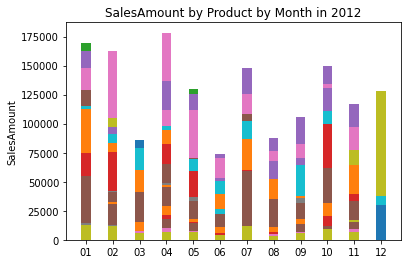

In [51]:
x_axis = df.OrderMonth.unique()
product_lst = list(df.ProductKey.unique())

width = 0.35      
fig, ax = plt.subplots()

for prod in product_lst:
    y = [0] * len(x_axis)
    for ix, row in df[df['ProductKey']==prod].iterrows():
        y[np.int(row['OrderMonth']) -1] =  row['SalesAmount']
    
    ax.bar(x_axis, y, width, label=str(prod))

ax.set_ylabel('SalesAmount')
ax.set_title('SalesAmount by Product by Month in 2012')


plt.show()



## Q5 . 5. Write a query to find the age of the customers. Bucket them under **Age Group**

1. We have negligible customers with Age less than 35
2. We see overall slighly more females than than males in our customer base and this is tru for both higher age groups
3. We have more singles in our 35-50 age group as customers. The ratio shifts when we focus on the older age group, that has more married customers


In [54]:
qa5 = pd.read_sql_query ( """
WITH data AS (
SELECT 
	dc."MaritalStatus" AS marital_status, 
	dc."Gender" AS gender, 
	CAST(strftime('%Y',  DATE('now')) AS integer) - CAST(strftime('%Y',  dc."BirthDate") AS intger) as age
FROM 
	dimcustomer_normalized dc
) 

SELECT 
	marital_status, 
	gender, 
	SUM(CASE WHEN age < 35 THEN 1 ELSE 0 END) AS age_less_than_35,
	SUM(CASE WHEN age >= 35 AND age <=50 THEN 1 ELSE 0 END) AS age_between_35_50,
	SUM(CASE WHEN age > 50 THEN 1 ELSE 0 END) AS age_more_than_50
FROM 
	data
GROUP BY marital_status, 
	gender
""", con = conn_s)

df = qa5.copy()

In [55]:
display(df)

,marital_status,gender,age_less_than_35,age_between_35_50,age_more_than_50
0,M,F,8,1926,2811
1,M,M,5,2124,3137
2,S,F,2,2494,1892
3,S,M,3,2358,1724


<AxesSubplot:>

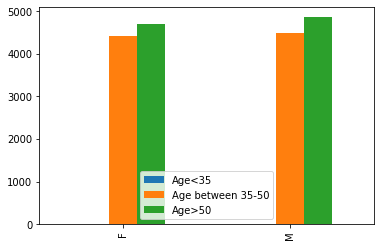

In [56]:
gender = df.groupby('gender', as_index = False)[['age_less_than_35', 'age_between_35_50', 'age_more_than_50']].sum()

img = pd.DataFrame(
    {
        'Age<35': list(gender.age_less_than_35), 
        'Age between 35-50': list(gender.age_between_35_50), 
        'Age>50': list(gender.age_more_than_50), 
    },
    index = list(gender.gender)
)
img.plot.bar()

<AxesSubplot:>

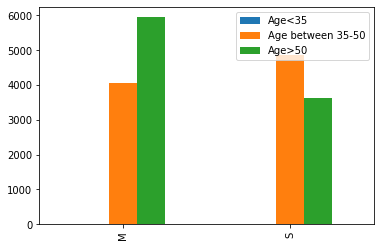

In [57]:
marital_status = df.groupby('marital_status', as_index = False)[['age_less_than_35', 'age_between_35_50', 'age_more_than_50']].sum()

img = pd.DataFrame(
    {
        'Age<35': list(marital_status.age_less_than_35), 
        'Age between 35-50': list(marital_status.age_between_35_50), 
        'Age>50': list(marital_status.age_more_than_50), 
    },
    index = list(marital_status.marital_status)
)
img.plot.bar()